# **Walmart : predict weekly sales**

## Company's Description 📇

Walmart Inc. is an American multinational retail corporation that operates a chain of hypermarkets, discount department stores, and grocery stores from the United States, headquartered in Bentonville, Arkansas. The company was founded by Sam Walton in 1962.

## Project 🚧

Walmart's marketing service has asked you to build a machine learning model able to estimate the weekly sales in their stores, with the best precision possible on the predictions made. Such a model would help them understand better how the sales are influenced by economic indicators, and might be used to plan future marketing campaigns.

## Goals 🎯

The project can be divided into three steps:

- Part 1 : make an EDA and all the necessary preprocessings to prepare data for machine learning
- Part 2 : train a **linear regression model** (baseline)
- Part 3 : avoid overfitting by training a **regularized regression model**

## Scope of this project 🖼️

For this project, you'll work with a dataset that contains information about weekly sales achieved by different Walmart stores, and other variables such as the unemployment rate or the fuel price, that might be useful for predicting the amount of sales. The dataset has been taken from a Kaggle competition, but we made some changes compared to the original data. Please make sure that you're using **our** custom dataset (available on JULIE). 🤓

## Deliverable 📬

To complete this project, your team should: 

- Create some visualizations
- Train at least one **linear regression model** on the dataset, that predicts the amount of weekly sales as a function of the other variables
- Assess the performances of the model by using a metric that is relevant for regression problems
- Interpret the coefficients of the model to identify what features are important for the prediction
- Train at least one model with **regularization (Lasso or Ridge)** to reduce overfitting


# LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

# PART 1: EDA / PREPROCESSING

In [2]:
sales = pd.read_csv('data.csv')

In [3]:
print("Dataset shape: ",sales.shape)
print("")
print("Dataset infos: ")
print("")
sales.info()
print("")
print("Dataset description: ")
print("")
display(sales.describe(include='all'))
print("Missing values (%): ")
print("")
print(round(100*sales.isnull().sum()/sales.shape[0] , 1))

Dataset shape:  (150, 8)

Dataset infos: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB

Dataset description: 



,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


Missing values (%): 

Store            0.0
Date            12.0
Weekly_Sales     9.3
Holiday_Flag     8.0
Temperature     12.0
Fuel_Price       9.3
CPI              8.0
Unemployment    10.0
dtype: float64


- The **shape** shows that we have a very small dataset for machine learning (only 150 rows! very uncommon for a machine learning, not illustrating at all what we can usually encounter), with 8 columns containing all variables.
- The **info** shows one variable, Date, which is of type object, involving some necessary processings later. 
- The **description** explains each variable: 

        Target variable: 
                
                Weekly_Sales (quantitative) (from 0.3K to 2.8K)

        Explanative variables:

            Categorical: 
                Store (number of the store from 1 to 20)
                Holiday_Flag (wether 0 or 1)

            Quantitave:
                Temperature (from 19 to 92 degree Farenheit)
                Date (we will change Datetime to numerical objects)
                Fuel_Price (from 2.5 to 4.2)
                CPI (from 126 to 227) ("Consumer Price Index", reflects inflation/deflation)
                Unemployment (from 5 to 13)
                
- Finally, there is a lot of **missing values**. In the target variable we will remove those rows now. For other variables, we will mostly replace them later with scikit-learn. 

In [4]:
# Removal of missing values in target variable: 
sales = sales[sales['Weekly_Sales'].isna() == False]
# Change variable Date to be able to include it in machine learning
sales['Date'] =  pd.to_datetime(sales['Date'])
sales['Year'] = sales.Date.dt.year
sales['Month'] = sales.Date.dt.month
sales['Day'] = sales.Date.dt.day
sales['Day_of_week'] = sales.Date.dt.weekday
sales = sales.drop(columns=['Date'])

C:\Users\elodi\AppData\Local\Temp\ipykernel_12460\4210236547.py:4: UserWarning: Parsing '18-02-2011' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sales['Date'] =  pd.to_datetime(sales['Date'])
C:\Users\elodi\AppData\Local\Temp\ipykernel_12460\4210236547.py:4: UserWarning: Parsing '25-03-2011' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sales['Date'] =  pd.to_datetime(sales['Date'])
C:\Users\elodi\AppData\Local\Temp\ipykernel_12460\4210236547.py:4: UserWarning: Parsing '28-05-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sales['Date'] =  pd.to_datetime(sales['Date'])
C:\Users\elodi\AppData\Local\Temp\ipykernel_12460\4210236547.py:4: UserWarning: Parsing '19-08-2011' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  sales['Date'] =  pd.to_datetime(sales['Date'])
C:\U

Now we can already have a look at all variables. First, we see on the graph below that the target variable is evenly distributed and does not have outliers.

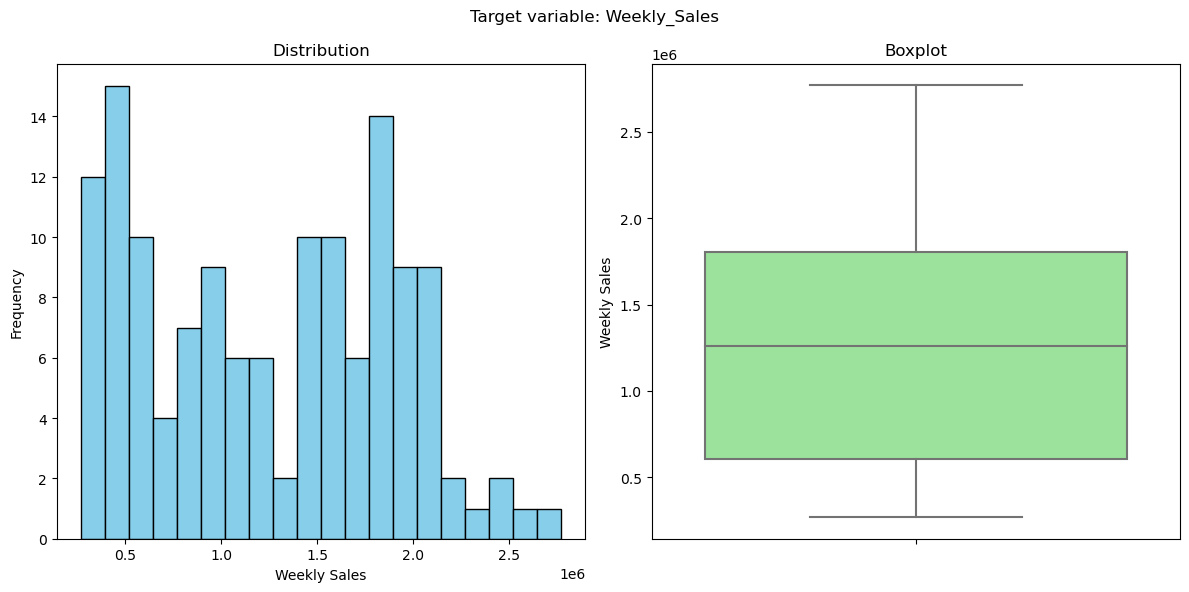

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Histogram
axes[0].hist(sales['Weekly_Sales'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution')
axes[0].set_xlabel('Weekly Sales')
axes[0].set_ylabel('Frequency')

# Boxplot
sns.boxplot(data=sales, y='Weekly_Sales', ax=axes[1], color='lightgreen')
axes[1].set_title('Boxplot')
axes[1].set_ylabel('Weekly Sales')

plt.suptitle('Target variable: Weekly_Sales')
plt.tight_layout()
plt.show()

**Categorical variables**: Below, we can see that we have data for the 20 stores even though the data is not well distributed. For the variable Holiday_Flag, the data is very imbalanced: the category 1 (meaning it is a holiday) represents only 6.62% of this variable.

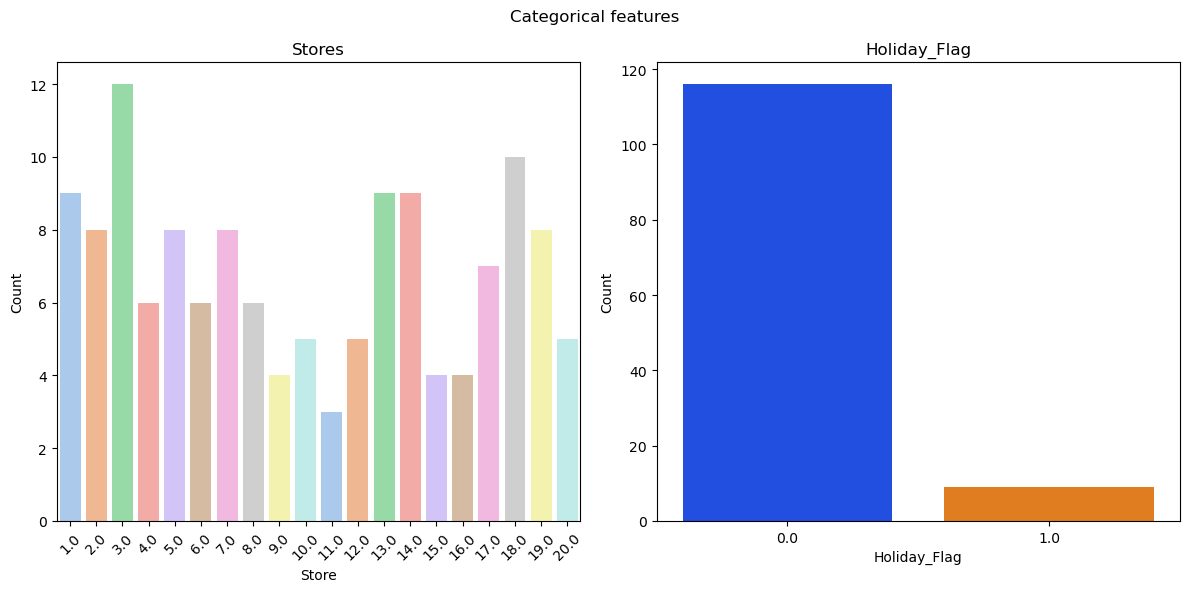

Percentage of holiday flag: 6.62 %


In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Bar chart for "Store"
store_counts = sales['Store'].value_counts()
sns.barplot(x=store_counts.index, y=store_counts.values, ax=axes[0], palette='pastel')
axes[0].set_title('Stores')
axes[0].set_xlabel('Store')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Bar chart for "Holiday_Flag"
holiday_counts = sales['Holiday_Flag'].value_counts()
sns.barplot(x=holiday_counts.index, y=holiday_counts.values, ax=axes[1], palette='bright')
axes[1].set_title('Holiday_Flag')
axes[1].set_xlabel('Holiday_Flag')
axes[1].set_ylabel('Count')

plt.suptitle('Categorical features')
plt.tight_layout()
plt.show()

# Percentage of 'Holiday_Flag' with value 1
holiday_flag_counts = sales['Holiday_Flag'].value_counts()
percentage_holiday_flag_1 = (holiday_flag_counts[1] / len(sales['Holiday_Flag'])) * 100
print(f"Percentage of holiday flag: {percentage_holiday_flag_1:.2f} %")

**Quantitative variables**

We can see here some outliers.

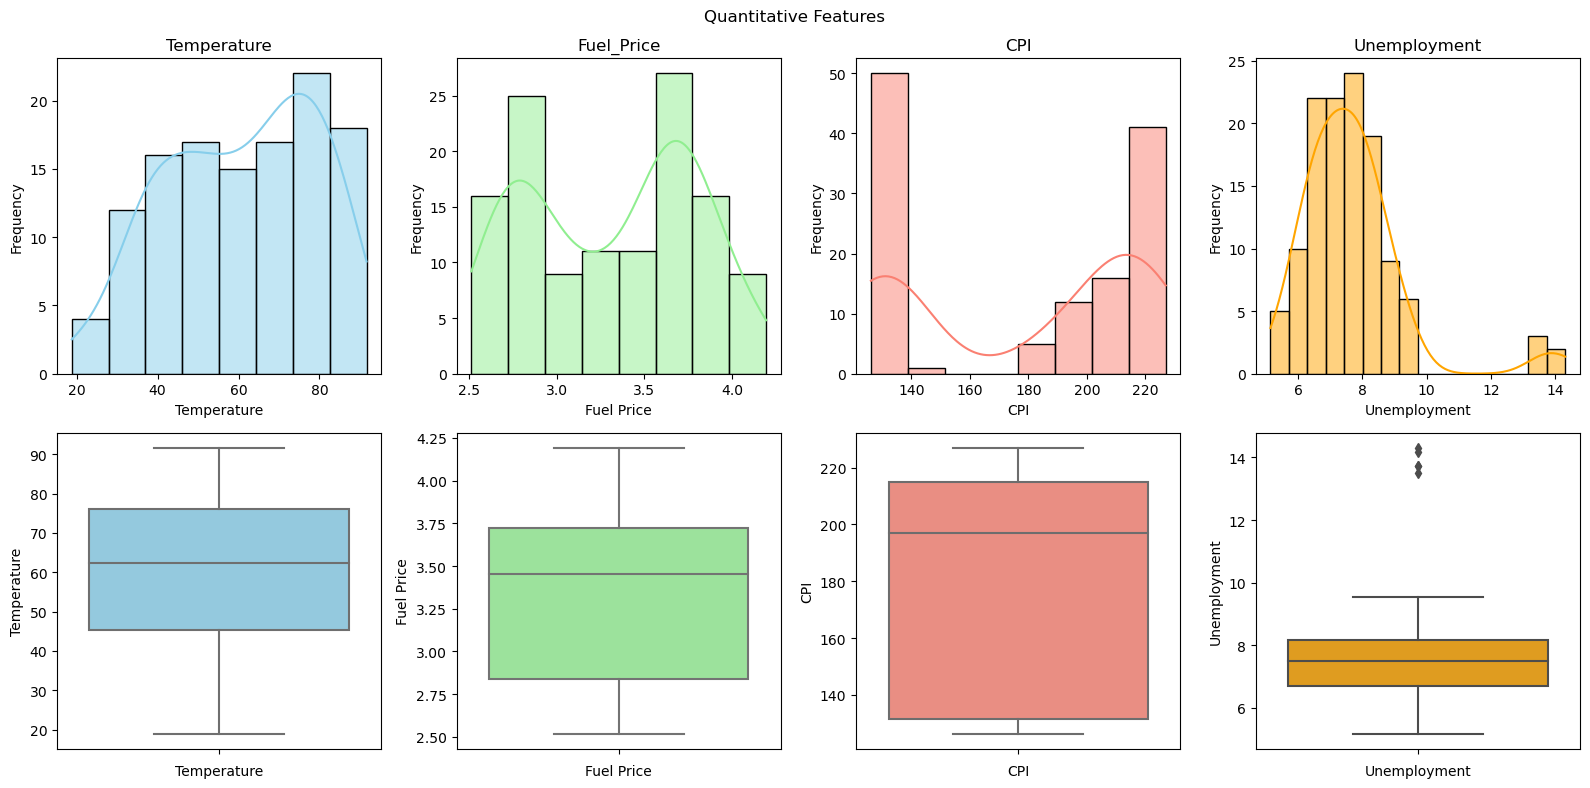

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

# First row - Histograms
sns.histplot(data=sales, x='Temperature', kde=True, ax=axes[0, 0], color='skyblue', edgecolor='black')
axes[0, 0].set_title('Temperature')
axes[0, 0].set_xlabel('Temperature')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(data=sales, x='Fuel_Price', kde=True, ax=axes[0, 1], color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Fuel_Price')
axes[0, 1].set_xlabel('Fuel Price')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(data=sales, x='CPI', kde=True, ax=axes[0, 2], color='salmon', edgecolor='black')
axes[0, 2].set_title('CPI')
axes[0, 2].set_xlabel('CPI')
axes[0, 2].set_ylabel('Frequency')

sns.histplot(data=sales, x='Unemployment', kde=True, ax=axes[0, 3], color='orange', edgecolor='black')
axes[0, 3].set_title('Unemployment')
axes[0, 3].set_xlabel('Unemployment')
axes[0, 3].set_ylabel('Frequency')

# Second row - Boxplots
sns.boxplot(data=sales, y='Temperature', ax=axes[1, 0], color='skyblue')
axes[1, 0].set_xlabel('Temperature')
axes[1, 0].set_ylabel('Temperature')

sns.boxplot(data=sales, y='Fuel_Price', ax=axes[1, 1], color='lightgreen')
axes[1, 1].set_xlabel('Fuel Price')
axes[1, 1].set_ylabel('Fuel Price')

sns.boxplot(data=sales, y='CPI', ax=axes[1, 2], color='salmon')
axes[1, 2].set_xlabel('CPI')
axes[1, 2].set_ylabel('CPI')

sns.boxplot(data=sales, y='Unemployment', ax=axes[1, 3], color='orange')
axes[1, 3].set_xlabel('Unemployment')
axes[1, 3].set_ylabel('Unemployment')

plt.suptitle('Quantitative Features')
plt.tight_layout()
plt.show()


**Outliers removal :**

In this project, will be considered as outliers all the numeric features that don't fall within the range : $[\bar{X} - 3\sigma, \bar{X} + 3\sigma]$. This concerns the columns : Temperature, Fuel_price, CPI and Unemployment. Two methods can be employed: removal of outliers in parallel or sequentially. In the first case, we calculate the mean and standard deviation of the 4 variables, then we remove outliers with the above formula. In the second case, we calculate mean and standard deviation of a first variable, remove outliers of this variable with the formula, then from the new dataset created we calculate the mean and standard deviation of a second variable, remove its outliers, etc sequentially. Both methods can be used. With the one in parallel, we might create new outliers ; with the sequential method, we are sure to get rid of all outliers but we loose a lot of data (in our case, from 150 to 90 rows, which is really few for machine learning). We will choose the sequential method, as it seems the most appropriate for a real case study (here the case is anyway not "real", starting from 150 rows).

In [8]:
# First method: outliers removal in PARALLEL

# def remove_outliers(df, columns):
#     for col in columns:
#         mean = df[col].mean()
#         std = df[col].std()
#         lower_range = mean - 3 * std
#         upper_range = mean + 3 * std
#         outliers = df[(df[col] < lower_range) | (df[col] > upper_range)]
#         df.drop(outliers.index, inplace=True)
#     return df
# sales = remove_outliers(sales, columns=['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'])
# print(len(sales))

# Second method: outliers removal SEQUENTIALLY

print(len(sales))
CPI_to_keep = (sales['CPI'] > (sales['CPI'].mean() - 3 * sales['CPI'].std())) & (sales['CPI'] < (sales['CPI'].mean() + 3 * sales['CPI'].std()))
sales = sales.loc[CPI_to_keep,:]
print(len(sales))

Temperature_to_keep = (sales['Temperature'] > (sales['Temperature'].mean() - 3 * sales['Temperature'].std())) & (sales['Temperature'] < (sales['Temperature'].mean() + 3 * sales['Temperature'].std()))
sales = sales.loc[Temperature_to_keep,:]
print(len(sales))

Fuel_Price_to_keep = (sales['Fuel_Price'] > (sales['Fuel_Price'].mean() - 3 * sales['Fuel_Price'].std())) & (sales['Fuel_Price'] < (sales['Fuel_Price'].mean() + 3 * sales['Fuel_Price'].std()))
sales = sales.loc[Fuel_Price_to_keep,:]
print(len(sales))

Unemployment_to_keep = (sales['Unemployment'] > (sales['Unemployment'].mean() - 3 * sales['Unemployment'].std())) & (sales['Unemployment'] < (sales['Unemployment'].mean() + 3 * sales['Unemployment'].std()))
sales = sales.loc[Unemployment_to_keep,:]
print(len(sales))

136
125
110
102
90


In [9]:
valeursnulles = round(100*sales.isnull().sum()/sales.shape[0] , 1)
print(valeursnulles)

Store            0.0
Weekly_Sales     0.0
Holiday_Flag    11.1
Temperature      0.0
Fuel_Price       0.0
CPI              0.0
Unemployment     0.0
Year            11.1
Month           11.1
Day             11.1
Day_of_week     11.1
dtype: float64


If we look at the **Date variables**, we can see that most sales happen on day 4 (friday), and that sales increase in December (Christmas), decrease a lot in January (after Christmas), there is a pick in March (sales?), then it is quite high before summer (April, May, June). Concerning the year, we have only 3 years represented, sales decrease each year but not significatively.

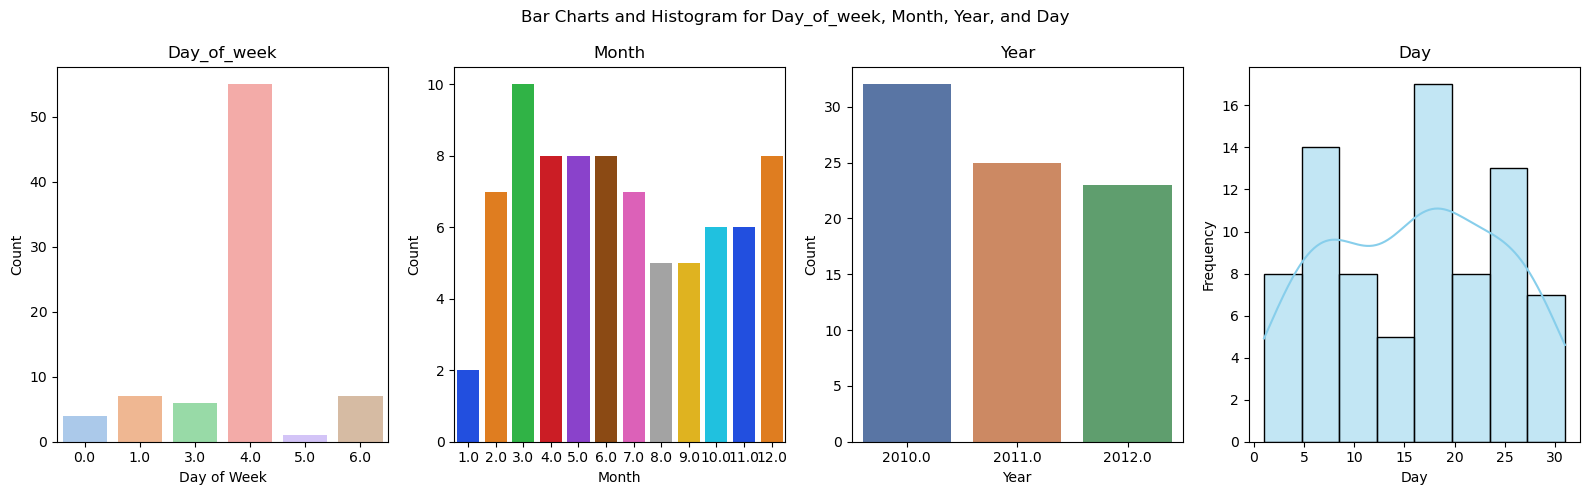

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 5))

# Bar chart for "Day_of_week"
sns.countplot(data=sales, x='Day_of_week', ax=axes[0], palette='pastel')
axes[0].set_title('Day_of_week')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Count')

# Bar chart for "Month"
sns.countplot(data=sales, x='Month', ax=axes[1], palette='bright')
axes[1].set_title('Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Count')

# Bar chart for "Year"
sns.countplot(data=sales, x='Year', ax=axes[2], palette='deep')
axes[2].set_title('Year')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Count')

# Histogram for "Day"
sns.histplot(data=sales, x='Day', kde=True, ax=axes[3], color='skyblue', edgecolor='black')
axes[3].set_title('Day')
axes[3].set_xlabel('Day')
axes[3].set_ylabel('Frequency')

# Set the title for the entire subplot
plt.suptitle('Bar Charts and Histogram for Day_of_week, Month, Year, and Day')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


Looking at pairwise dependencies and matrix correlation below, it seems that CPI is the most correlated variable with Weekly_Sales. Then come Day_of_week and Store, then come Temperature and Unemployment. Holiday_Flag does not seem correlated at all, which is surprising, but it could also have a non linear correlation. We also observe that there might be multicolinearity between exaplanative variables. Indeed, Fuel_Price / Year have a strong correlation (0.85!!), CPI / Store and Month / Holiday_Flag have a strong anti-correlation. We might have to remove some of those variables or proceed with a PCA (Principal Component Analysis) to handle this problem better.

In [11]:
fig = px.scatter_matrix(sales)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height = 1200, width = 1200)
fig.show()

corr_matrix = sales.corr().round(2)

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())
fig.show()

# PART 2: BASELINE (Linear Regression)

 **Explanatory variables (X)**
We need to identify which columns contain categorical variables and which columns contain numerical variables, as they will be treated differently. Date variables are a bit specific: they could be considered categorical but this would create too many variables after preprocessing (each category becomes a variable, which means each month, each day etc), which might lead to overfitting. We could treat them as numeric but this can lead to several issues and misconceptions: we would loose some important information (is it a weekend, a special month like christmas etc), we might create incorrect mathematical relationships, we would loose the cyclic pattern (january is following december) etc. For those reasons, we will treat date variables specifically.

 - Categorical variables : Store, Holiday_Flag
 - Numerical variables : Temperature, Fuel_Price, CPI, Unemployment
 - Date variables: Year, Month, Day, Day_of_week

 Machine Learning: We started with only one variable 'Store' which seemed the most important (EDA), the R2 score for test was 0.9356374511310719. When adding all variables we saw that the R2 for train and test were decreasing. So we started over from only 'Store', and added variables one by one, checking every time if the R2 scores were improved or not. We added 'Day', it decreased, so we removed this variable. We added Day_of_week, it increased to 0.936 so we kept it. Adding 'Unemployement' decrease R2, left. 'Fuel_Price increased, kept (0.9391421928101414). CPI increased, kept (0.9435736599012037). Holiday_Flag, Month, Year, Temperature decreased R2, all left. So only 4 variables remain now: Store, Day_of_week, Fuel_Price and CPI.

In [12]:
# features_list = ['Day_of_week','Day','Month','Year','Unemployment','CPI','Fuel_Price','Temperature','Holiday_Flag','Store']
# numeric_indices = [4,5,6,7]
# categorical_indices = [8,9]
# date_indices = [0,1,2,3]

features_list = ['Store','Day_of_week','Fuel_Price','CPI']
X = sales.loc[:,features_list]
numeric_indices = [2,3]
categorical_indices = [0]
date_indices = [1]

target_variable = "Weekly_Sales"
Y = sales.loc[:,target_variable]

In [13]:
print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Y : 
0    1572117.54
1    1807545.43
4    1644470.66
6     695396.19
7    2203523.20
Name: Weekly_Sales, dtype: float64

X :
   Store  Day_of_week  Fuel_Price         CPI
0    6.0          4.0       3.045  214.777523
1   13.0          4.0       3.435  128.616064
4    6.0          4.0       2.759  212.412888
6   15.0          6.0       4.069  134.855161
7   20.0          4.0       3.617  213.023622
Dividing into train and test sets...
...Done.



We still need to do some preprocessing steps.

In [14]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first',handle_unknown='ignore')) # first column will be dropped to avoid creating correlations between features; handle_unknown in case some categories are not in train and test
    ])

# Create pipeline for date features
date_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # for dates it makes no sense to choose a median !
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    # It is not great to scale dates, and one-hot-encoder will create too many columns. 
    # This is more relevant and can be used in our case as our dates are ordered. 
    ])

# Applying pipeline on X variables depending on columns
feature_encoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices),
        ('date',date_transformer, date_indices)
        ]
    )

In [15]:
print("Performing preprocessings on train set...")
# X_train_dense = X_train.toarray() # Convert the sparse matrix to a dense NumPy array
# print(X_train_dense[:5])
print(X_train[:5])
X_train_transformed = feature_encoder.fit_transform(X_train)
print('...Done.')
print(X_train_transformed[:5])
print()

print("Performing preprocessings on test set...")
# X_test_dense = X_test.toarray()
# print(X_test_dense[:5])
print(X_test[:5])
X_test_transformed = feature_encoder.transform(X_test)
print('...Done.')
print(X_test_transformed[:5])
print()

Performing preprocessings on train set...
     Store  Day_of_week  Fuel_Price         CPI
127   16.0          1.0       2.711  189.523128
63     5.0          4.0       3.594  224.019287
35    19.0          4.0       3.789  133.958742
10     8.0          4.0       3.554  219.070197
95     1.0          4.0       2.854  210.337426
...Done.
  (0, 13)	1.0
  (0, 18)	-1.2684064129831014
  (0, 19)	0.20507787897090277
  (0, 20)	1.0
  (1, 3)	1.0
  (1, 18)	0.5805882929947872
  (1, 19)	1.092603852656994
  (1, 20)	3.0
  (2, 16)	1.0
  (2, 18)	0.988916682197153
  (2, 19)	-1.2244967736725922
  (2, 20)	3.0
  (3, 6)	1.0
  (3, 18)	0.49682862341481476
  (3, 19)	0.9652723930663473
  (3, 20)	3.0
  (4, 18)	-0.9689655942347007
  (4, 19)	0.740593446601042
  (4, 20)	3.0

Performing preprocessings on test set...
     Store  Day_of_week  Fuel_Price         CPI
4      6.0          4.0       2.759  212.412888
20     7.0          3.0       2.725  189.704822
82    11.0          NaN       3.510  223.917015
61    10.0 

c:\Users\elodi\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

c:\Users\elodi\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



In [16]:
# Preprocessing target variable

Y_train = Y_train.values.reshape(-1, 1)
Y_test = Y_test.values.reshape(-1, 1)

scaler = StandardScaler()

print("Preprocessing Y_train and Y_test")
Y_train_transformed = scaler.fit_transform(Y_train)
print(Y_train_transformed[0:5,:])
Y_test_transformed = scaler.transform(Y_test)
print(Y_test_transformed[0:5,:])

Preprocessing Y_train and Y_test
[[-0.98993504]
 [-1.45531966]
 [ 0.01897373]
 [-0.55561061]
 [ 0.37112899]]
[[ 0.603468  ]
 [-1.07207572]
 [ 0.4876803 ]
 [ 1.13846063]
 [-1.29115674]]


In [17]:
# Train model
print("Train model...")
regressor = LinearRegression() # The target being numerical, we use linear regression.
regressor.fit(X_train_transformed, Y_train_transformed)
print("...Done.")

# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train_transformed)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test_transformed)
print("...Done.")
print(Y_test_pred)
print()

# R^2 scores
r2_train = r2_score(Y_train_transformed, Y_train_pred)
r2_test = r2_score(Y_test_transformed, Y_test_pred)

Train model...
...Done.
Predictions on training set...
...Done.
[[-1.01567192]
 [-1.33785137]
 [ 0.13586105]
 [-0.6397106 ]
 [ 0.44571241]
 [ 0.53422091]
 [ 1.21033381]
 [-0.95432595]
 [-0.51452134]
 [-0.24597715]
 [ 1.3037203 ]
 [-1.04624834]
 [ 1.21866653]
 [-1.01021249]
 [-1.1431325 ]
 [-0.65642889]
 [-0.92171279]
 [ 0.54107409]
 [-1.56603347]
 [-1.12906202]
 [ 0.87973031]
 [ 1.20060398]
 [-0.20944911]
 [ 0.18205188]
 [ 1.24102412]
 [ 1.14772845]
 [-1.28850592]
 [ 1.30879612]
 [-0.49195078]
 [ 0.53353466]
 [ 1.15143184]
 [ 0.56393403]
 [ 0.52247849]
 [ 0.93385096]
 [-1.38130871]
 [-1.18196815]
 [-0.66099365]
 [ 0.25650284]
 [ 1.12924855]
 [ 1.18288604]
 [-1.16491807]
 [ 1.1755843 ]
 [ 0.33895525]
 [-1.29365306]
 [-1.60560977]
 [-1.13662072]
 [-1.24082904]
 [ 0.97947504]
 [ 1.17583434]
 [-1.2242442 ]
 [ 1.26919142]
 [ 1.08847869]
 [-0.6252962 ]
 [ 0.40816118]
 [-1.16062764]
 [-1.40782519]
 [ 0.82869593]
 [-1.34598635]
 [-0.52193068]
 [ 1.47437419]
 [ 0.79089416]
 [-0.16555537]
 [ 0.7

In [18]:
print("r2_train: ", r2_train)
print("r2_test: ", r2_test)
scores = cross_val_score(regressor,X_train_transformed, Y_train_transformed, cv=10)
avg = scores.mean()
std = scores.std()
print('Cross-validated accuracy : {}\nstandard deviation : {}'.format(avg, std))

r2_train:  0.9817952834289124
r2_test:  0.9435736599012037
Cross-validated accuracy : 0.9601955116174439
standard deviation : 0.022671665477082287


In [19]:
#  Create the variable "results" where we will store all data from nowon.

results = [{
    'Model': "Linear Regression",
    'R2 Train Score': r2_train,
    'R2 Test Score': avg,
}]

The final R2 score for test after cross validation is of 0.96 plus or minus 0.02. We reach quite high R2 scores for train and test already (train is 0.98). However, we have some overfitting as the train is higher than the test. 

Now let's check features importance. On the graph below, we see the high importance of many stores. Maybe some stores are located at some places much easier to reach than others, for example where a lot of metro lines are crossing or in an area where a lot of business companies are located so people can go after work easily. And that would explain more than anything else the weekly sales.

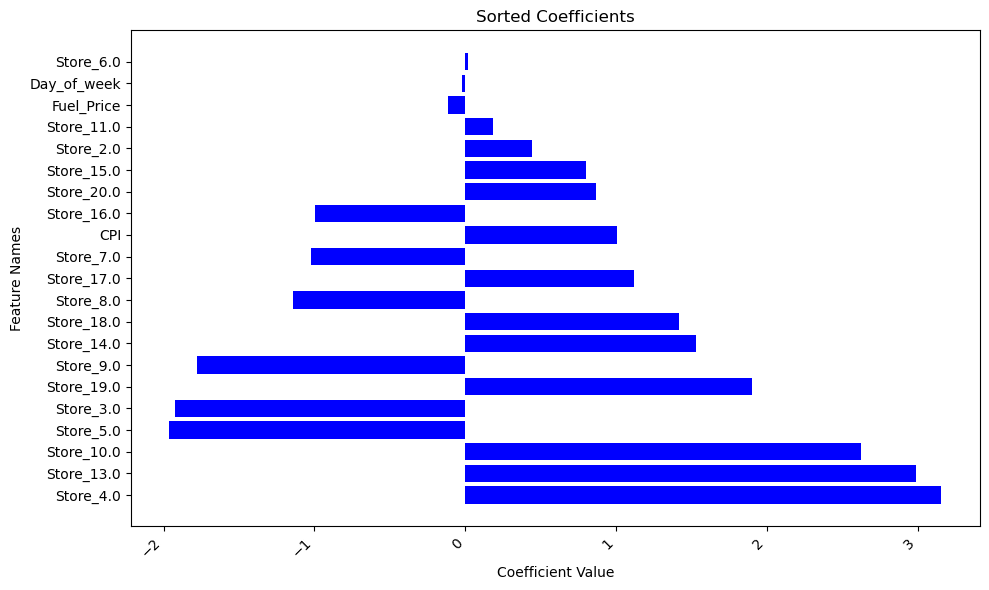

In [24]:
# Data before preprocessing
all_features_df = pd.concat([X_train, X_test], ignore_index=True)

# Column names after preprocessing
num_names = all_features_df.columns[numeric_indices].tolist()
date_names = all_features_df.columns[date_indices].tolist()
categorical_encoder = feature_encoder.named_transformers_['cat']['encoder'] # for categorical we need to decode
cat_names = categorical_encoder.get_feature_names_out(input_features=all_features_df.columns[categorical_indices])
all_feature_names = list(cat_names) + num_names + date_names # now we have each category of each variable names

# Combine the feature names and coefficients into a DataFrame
coefs = pd.DataFrame(index=all_feature_names, data=regressor.coef_.flatten(), columns=["coefficients"])
coefs_sorted = coefs.reindex(coefs['coefficients'].abs().sort_values(ascending=False).index)

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(coefs_sorted)), coefs_sorted['coefficients'], color='blue')
plt.yticks(np.arange(len(coefs_sorted)), coefs_sorted.index)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Names')
plt.title('Sorted Coefficients')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# PART 3: REDUCTION OF OVERFITTING

Ridge and Lasso are two methods that are used to regularize a linear regression and avoid overfitting, by adding a penalty term to the regression equation. In Ridge, the penalty is proportional to the square of the coefficients' magnitudes to the loss function, it prevents them from getting to high (it reduces them but not to zero). In Lasso, the penalty is proportional to the absolute values of the coefficients. It forces some coefficients to become zero, leading to features selection. Let's do a gridsearch for each method in order to find the best hyperparameters and see how we improve our baseline linear regression.

In [25]:
models = {
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.00001, 0.00005, 0.0001, 0.0005, 0.001,  0.005, 0.01, 0.1, 1.0, 10, 100],
            'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
            'max_iter': [100, 200, 500, 1000, 5000],
            'tol': [1e-3, 1e-4, 1e-5]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1.0, 10, 100],
            'selection': ['cyclic', 'random'],
            'max_iter': [100, 200, 500, 1000, 5000],
            'tol': [1e-3, 1e-4, 1e-5]
        }
    }
}

In [ ]:
for name, model_info in models.items():
    model = model_info['model']
    params = model_info['params']
    
    grid_search = GridSearchCV(model, params, cv=10, scoring='r2')
    grid_search.fit(X_train_transformed, Y_train_transformed)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    # Predictions
    Y_train_pred = best_model.predict(X_train_transformed)
    Y_test_pred = best_model.predict(X_test_transformed)
    
    # Metrics
    r2_train = r2_score(Y_train_transformed, Y_train_pred)
    r2_test = r2_score(Y_test_transformed, Y_test_pred)
    mae_test = mean_absolute_error(Y_test_transformed, Y_test_pred)
    mse_test = mean_squared_error(Y_test_transformed, Y_test_pred)
    rmse_test = np.sqrt(mse_test)

    results.append({
        'Model': name,
        'Alpha': best_params['alpha'],
        'R2 Train Score': r2_train,
        'R2 Test Score': r2_test,
        'MAE Test': mae_test,
        'MSE Test': mse_test,
        'RMSE Test': rmse_test,
    })


In [27]:
results_df = pd.DataFrame(results)
print(results_df)

               Model  R2 Train Score  R2 Test Score    Alpha  MAE Test  \
0  Linear Regression        0.981795       0.960196      NaN       NaN   
1              Ridge        0.981794       0.943547  0.00010  0.160666   
2              Lasso        0.981782       0.943451  0.00001  0.160673   

   MSE Test  RMSE Test  
0       NaN        NaN  
1  0.068101   0.260963  
2  0.068217   0.261183  


Here we see that the gridsearch selects for Ridge and Lasso always the smallest alpha (here 0.00001 was the smallest tried). This means that the penalty created by the regularization is minimized a lot, it is almost as if we did not do any regularization. And still, r2 scores for the test are not as good as the baseline linear regression (0.94 whereas no regularization has 0.96), while r2 scores for the train remains the same (0.98). So regularization is definitely not helping here, and the best results obtained are still with a simple linear regression. This might be linked to the fact that we already selected the 4 best features in the beginning.